In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src import utils
import seaborn as sns
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import norm, multivariate_normal, probplot


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [21]:
sns.set_theme()
beta_true = .15
alpha = 0.1
gamma = 0.05
N = 100
T = 52
seed = 29

In [22]:
F = np.arange(N) % 5
R = np.arange(N) % (N // 2)
fC = utils.contact_matrix(F)
rC = utils.contact_matrix(R)

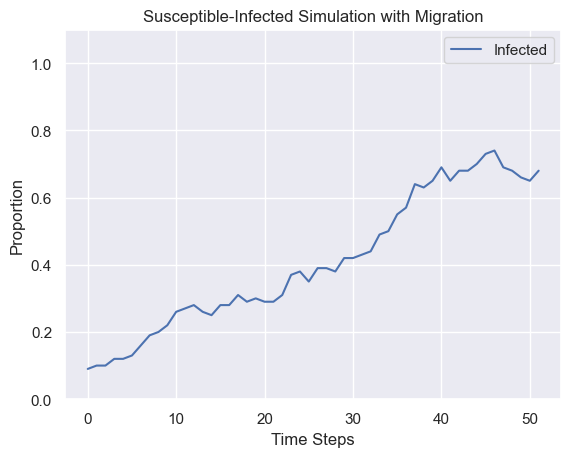

In [23]:
X_o = utils.simulator(alpha, beta_true, gamma, N, T, seed)
I_o = X_o.sum(0).astype(int)
plt.plot(I_o / N, label="Infected")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

## Homogeneous Transmission

In [24]:
def f(beta):
    return - utils.x_loglikelihood(beta, alpha, gamma, N, T, X_o, het=False)

res = minimize_scalar(f, bounds=(0.01,1), method="bounded", options={"disp": True, "maxiter": 18})
res.x


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


0.13865727373214706

In [34]:
S = 100
M = - res.fun
sample = np.empty(S)
attempts = 0
np.random.seed(4)
for s in range(S):
    accept = False
    while not accept:
        logbeta = norm(-3, 1).rvs()
        attempts += 1
        u = np.random.uniform(0,1)
        if np.log(u) < utils.x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o) - M:
            accept = True
            sample[s] = logbeta
        if attempts % 1000 == 0:
            print(attempts)
    
sample.mean(), sample.std(), np.exp(sample).mean(), np.exp(sample).std()

1000


(-1.9890873054325824,
 0.08796864585450709,
 0.1373495258483031,
 0.012080353821885183)

In [35]:
attempts

1916

In [25]:
# np.random.seed(4)
S = 500
M = - res.fun
sample = np.empty(S)
attempts = 0
np.random.seed(4)
for s in range(S):
    accept = False
    while not accept:
        logbeta = norm(-3, 1).rvs()
        attempts += 1
        u = np.random.uniform(0,1)
        if np.log(u) < utils.x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o) - M:
            accept = True
            sample[s] = logbeta
        if attempts % 1000 == 0:
            print(attempts)
    
sample.mean(), sample.std(), np.exp(sample).mean(), np.exp(sample).std()

1000
2000
3000
4000
5000
6000
7000
8000


(-1.9896766625425661,
 0.09485686075128438,
 0.1373552100554482,
 0.013026813464384304)

In [9]:
np.exp(sample).std()

0.013026813464384304

In [17]:
dist = norm(0.137, 0.013)
dist.ppf(.05), dist.ppf(0.95)

(0.11561690284963086, 0.15838309715036913)

In [19]:
dist = norm(-1.99, 0.0949)
np.exp(dist.ppf(0.05)), np.exp(dist.ppf(0.95))

(0.11693972952240995, 0.15978863140907054)

(array([ 11.,  34.,  72., 104., 123.,  85.,  42.,  20.,   6.,   3.]),
 array([0.10425875, 0.11205235, 0.11984596, 0.12763956, 0.13543316,
        0.14322676, 0.15102036, 0.15881396, 0.16660757, 0.17440117,
        0.18219477]),
 <BarContainer object of 10 artists>)

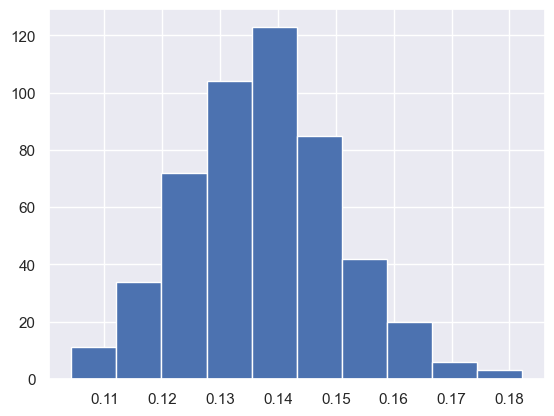

In [12]:
plt.hist(np.exp(sample))

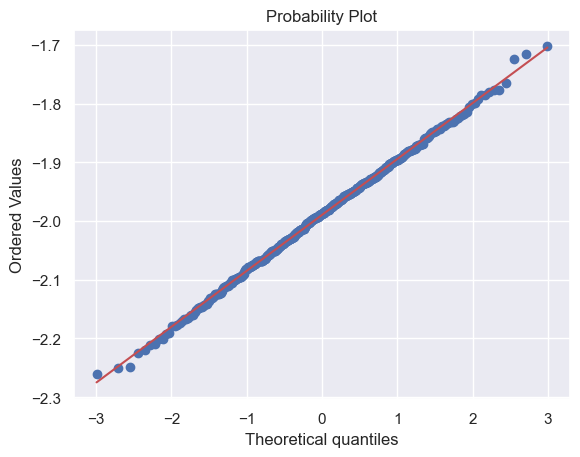

In [16]:
fig, ax = plt.subplots()
probplot(sample, dist="norm", plot=ax)
plt.show()

In [11]:
# np.random.seed(4)
# S = 100
S = 500
M = - res.fun
sample = np.empty(S)
attempts = 0
np.random.seed(4)
for s in range(S):
    accept = False
    while not accept:
        logbeta = norm(-3, 1).rvs()
        attempts += 1
        u = np.random.uniform(0,1)
        if np.log(u) < x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o) - M:
            accept = True
            sample[s] = logbeta
        if attempts % 1000 == 0:
            print(attempts)
    
sample.mean(), sample.std(), np.exp(sample).mean()

1000
2000
3000
4000
5000
6000
7000
8000


(-1.9896766625425661, 0.09485686075128438, 0.1373552100554482)

In [12]:
attempts, np.log10(attempts)

(8733, 3.941163460158473)

## Identifiability

In [13]:
def nll(beta, alpha, gamma, N, T, X, het):
    # beta = beta / np.array([1, 300, 300, 300, 300, 300, 300])
    return - utils.x_loglikelihood(beta, alpha, gamma, N, T, X, het)

In [19]:
res1 = minimize(
    nll, x0 = [0.15, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8], 
    args = (alpha, gamma, N, T, X_o, True),
    bounds = [(0.0, None) for _ in range(7)])
res1.x

array([0.06727668, 0.        , 0.25840772, 0.24056356, 0.27315892,
       0.32354824, 0.        ])

In [ ]:
def f2(beta):
    return - x_loglikelihood(beta, alpha, gamma, N, T, X_o, het=True)

res = minimize_scalar(f, bounds=(0.01,1), method="bounded", options={"disp": True, "maxiter": 18})
res.x

## Heterogeneous Transmission

In [3]:
beta_true = np.array([.05, .02, .04, .06, .08, .1, .05])
alpha = 0.1
gamma = 0.05
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
seed = 31

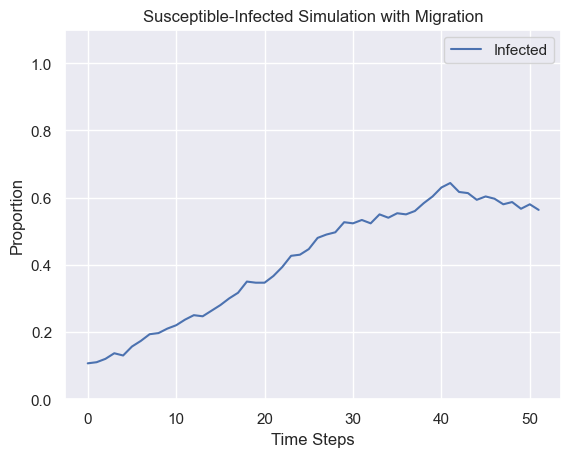

In [4]:
X_o = utils.simulator(alpha, beta_true, gamma, N, T, seed=31, het=True)
I_o = X_o.sum(0).astype(int)
plt.plot(I_o / N, label="Infected")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

In [10]:
res2 = minimize(
    utils.nll, x0 = beta_true, args = (alpha, gamma, N, T, X_o, True),
    bounds = [(0.0, None) for _ in range(7)], tol=0.0001
)
res2.x

array([0.04184008, 0.01823432, 0.07429405, 0.05571989, 0.07606811,
       0.1100845 , 0.04667092])

In [6]:
np.log(np.array([0.04968622, 0.09937244, 0.31859135, 0.29811733, 0.39748977,
       0.53240004, 5.00131303]))

array([-3.00202765, -2.30888047, -1.14384603, -1.21026815, -0.92258608,
       -0.63036012,  1.60970048])

In [18]:
res2.fun

2842.7474873568417

In [29]:
x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o, het=True)

-2898.7002914894024

In [39]:
theta_s = multivariate_normal(prior_mu).rvs()

In [40]:
prior.logpdf(theta_s)

-13.350427165604046

In [41]:
def loglike(logbeta):
    return x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o, het=True)

In [95]:
# metropolis hastings
prior = multivariate_normal(prior_mu)
S = 9000
post_sample = np.empty((S, 7))
theta_s = multivariate_normal(prior_mu).rvs()
sigma = 1
accept = np.empty(S)
post_sample[0] = theta_s
accept[0] = 1
post_cur = prior.logpdf(theta_s) + loglike(theta_s)
u = np.random.uniform(size=S)
np.random.seed(4)
for s in range(1, S):
    theta_t = multivariate_normal(theta_s, sigma).rvs()
    post_prop = prior.logpdf(theta_t) + loglike(theta_t)
    log_A = post_prop - post_cur
    if np.log(u[s]) <= log_A:
        theta_s = theta_t
        post_cur = post_prop
        accept[s] = True
    else:
        accept[s] = False
    post_sample[s] = theta_s
    
    if s % 1000 == 0: print(s)

1000
2000
3000
4000
5000
6000
7000
8000


In [ ]:
# .0572, .0961, .248, .175, .260, .502, 5.21

#### rejection sampling

In [19]:
prior_mu = np.array([-3, -3, -3, -3, -3, -3, -3])

S = 100
M = - res2.fun
sample = np.empty((S, 7))
attempts = 0
np.random.seed(4)
for s in range(S):
    accept = False
    while not accept:
        logbeta = multivariate_normal(prior_mu).rvs()
        attempts += 1
        u = np.random.uniform(0,1)
        if np.log(u) < utils.x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o, True) - M:
            accept = True
            sample[s] = logbeta
        if attempts % 500 == 0:
            print(attempts)
    print(s)
    
sample.mean(0), sample.std(0), np.exp(sample).mean(0)

500
1000


KeyboardInterrupt: 

### load posterior sample

In [7]:
ps = np.load("posterior_sample.npy")

In [8]:
np.exp(ps).mean(0)

array([0.05717566, 0.09610881, 0.24757036, 0.17536349, 0.29594678,
       0.50199447, 5.21070125])

In [9]:
np.exp(ps).std(0)

array([0.01243581, 0.05590532, 0.09396056, 0.08626314, 0.09054331,
       0.11512704, 1.68905677])